# **Assignment # 3**

#Humayun Malik
#21I-2562
#Section:D

#**Neural Network Notebook**

In [16]:
import pandas as pd
import re
import numpy as np
import pickle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split


# Load Data

In [17]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

file_path = "spam_or_not_spam.csv"  # Replace with your file's name
df = pd.read_csv(file_path)

Saving spam_or_not_spam.csv to spam_or_not_spam (1).csv


Pre-Processing

In [18]:
# Ensure all values in the 'email' column are strings
df['email'] = df['email'].astype(str)

# Preprocess emails
def preprocess_email(email):
    email = re.sub(r'[^\w\s]', '', email)  # Remove punctuation
    email = re.sub(r'\d+', '', email)  # Remove numbers
    email = email.lower()  # Convert to lowercase
    return email

df['email'] = df['email'].apply(preprocess_email)


# Load Embeddings

In [19]:
# Load trained word embeddings
uploaded = files.upload()
with open('trained_embeddings.pkl', 'rb') as file:
    trained_embeddings = pickle.load(file)
print("Embeddings loaded successfully.")


Saving trained_embeddings.pkl to trained_embeddings (1).pkl
Embeddings loaded successfully.


# Resampling

In [20]:
from sklearn.utils import resample
# Balance dataset
# Separate classes
spam = df[df['label'] == 1]
non_spam = df[df['label'] == 0]


# Resample to balance
if len(spam) > len(non_spam):
    spam = resample(spam, replace=False, n_samples=len(non_spam), random_state=42)
else:
    non_spam = resample(non_spam, replace=False, n_samples=len(spam), random_state=42)

df = pd.concat([spam, non_spam])

# Neural Network

In [27]:


# Set random seed for reproducibility
np.random.seed(42)

# Convert all emails to numerical embeddings
def process_email(email, embeddings, max_words=12, embedding_dim=10):
    words = email.split()[:max_words]  # Select the first 12 words
    words = words + ['<PAD>'] * (max_words - len(words))  # Pad with <PAD> if less than 12 words

    email_embedding = []
    for word in words:
        if word in embeddings:
            email_embedding.append(embeddings[word])
        else:
            email_embedding.append(np.zeros(embedding_dim))  # Zero-vector for unknown words
    while len(email_embedding) < max_words:
        email_embedding.append(np.zeros(embedding_dim))  # Padding
    return np.array(email_embedding).flatten()  # Flatten to 1D array

# Convert all emails to numerical embeddings
X = np.array([process_email(email, trained_embeddings) for email in df['email']])

# Extract labels
y = df['label'].values  # Assuming 'label' column exists (0 = not spam, 1 = spam)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network Parameters
input_dim = X_train.shape[1]  # 120 (12 words * 10 embedding dimensions)
hidden_dim = 2
output_dim = 1

# Initialization
def initialize_weights(input_dim, hidden_dim, output_dim):
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

# Initialize weights and biases
W1, b1, W2, b2 = initialize_weights(input_dim, hidden_dim, output_dim)

# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def sigmoid_derivative(z):
    return z * (1 - z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

# Forward pass
def forward_pass(X):
    global Z1, A1, Z2, A2  # Store intermediate values for backpropagation

    # Input to hidden layer
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)

    # Hidden to output layer
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)  # Final output

    return A2

# Backward pass
def backward_pass(X, y, A2, learning_rate=0.01):
    global W1, b1, W2, b2

    m = y.shape[0]
    dZ2 = A2 - y  # Loss derivative
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Update weights and biases
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

# Training loop
epochs = 1000
learning_rate = 0.01

for epoch in range(epochs):
    # Forward pass
    A2 = forward_pass(X_train)

    # Compute loss (binary cross-entropy)
    loss = -np.mean(y_train * np.log(A2 + 1e-9) + (1 - y_train) * np.log(1 - A2 + 1e-9))

    # Backward pass
    backward_pass(X_train, y_train.reshape(-1, 1), A2, learning_rate)


print(f"{epoch} Epochs Ran Successfully")


999 Epochs Ran Successfully


#Evaluation


In [45]:

# Evaluate the model
y_pred = forward_pass(X_test)
y_pred_labels = (y_pred > 0.45).astype(int)


# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8
Precision: 0.75
Recall: 0.875
F1-Score: 0.8076923076923077
Confusion Matrix:
 [[76 28]
 [12 84]]


# Visualization

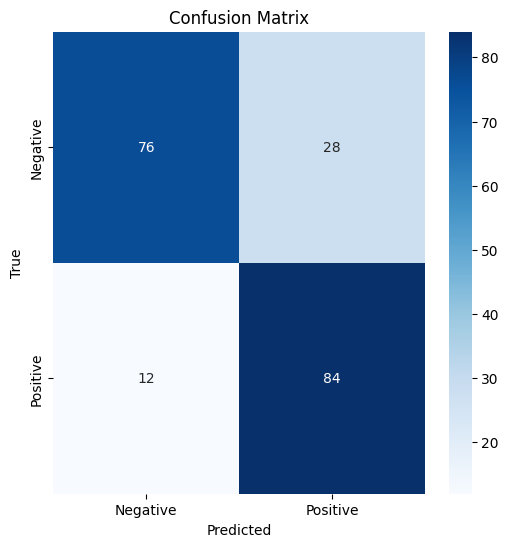

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
